In [1]:
from matplotlib.collections import LineCollection

from pprint import pprint

from deepracer.tracks import TrackIO, Track
from deepracer.tracks.track_utils import track_breakdown, track_meta
from deepracer.logs import \
    SimulationLogsIO as slio, \
    NewRewardUtils as nr, \
    AnalysisUtils as au, \
    PlottingUtils as pu, \
    ActionBreakdownUtils as abu, \
    DeepRacerLog

# Ignore deprecation warnings we have no power over
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import helper_utils

In [2]:
model_logs_root = '/Users/rohan/Documents/python-projects/deepracer/2022-October/Logs-SteerSpeedDist-Diff-8Hours'
log = DeepRacerLog(model_logs_root)

# load logs into a dataframe
log.load()

try:
    pprint(log.agent_and_network())
    print("-------------")
    pprint(log.hyperparameters())
    print("-------------")
    pprint(log.action_space())
except Exception:
    print("Robomaker logs not available")

df = log.dataframe()

{'network': 'DEEP_CONVOLUTIONAL_NETWORK_SHALLOW',
 'sensor_list': ['FRONT_FACING_CAMERA'],
 'simapp_version': '4'}
-------------
{'batch_size': 64,
 'beta_entropy': 0.01,
 'discount_factor': 0.999,
 'e_greedy_value': 0.05,
 'epsilon_steps': 10000,
 'exploration_type': 'categorical',
 'loss_type': 'huber',
 'lr': 0.0003,
 'num_episodes_between_training': 20,
 'num_epochs': 10,
 'stack_size': 1,
 'term_cond_avg_score': 350000000.0,
 'term_cond_max_episodes': 1000000000}
-------------
{'speed': {'high': 1.0, 'low': 0.5},
 'steering_angle': {'high': 30.0, 'low': -30.0}}


In [3]:
helper_utils.list_available_tracks()

['reInvent2019_track', '2022_august_open', 'Canada_Training', 'canada_race', 'Tokyo_Training_track', 'Oval_track', 'New_York_Track', 'Bowtie_track', 'H_track', 'reinvent_base', '2022_september_open', 'Mexico_track', 'Virtual_May19_Train_track', 'Straight_track', 'AWS_track', 'China_track', '2022_july_open', '2022_june_open', 'London_Loop_Train']


In [4]:
trackname="2022_september_open"

In [5]:
center_line, inner_border, outer_border = helper_utils.load_track_waypoints(trackname)

In [6]:
racing_line = helper_utils.load_py_to_ndarray('./racelines-populated/2022_september_open-cubspl-5.47-2022-12-25-210410.py')

In [7]:
npoints = len(racing_line) - 1

In [8]:
coords_start = df[df['steps'] == 1][['x', 'y']].to_numpy()
coords_start = np.unique(np.round(coords_start, 1), axis=0)

coords_desmos = np.array_repr(coords_start)
coords_desmos = coords_desmos[7:-2]
coords_desmos = coords_desmos.replace("       ", "")
coords_desmos = coords_desmos.replace("[", "(")
coords_desmos = coords_desmos.replace("],", ")")
coords_desmos = coords_desmos.replace("]", ")")

if coords_start.shape[0] != 20:
    print("Please remove duplicates from round robin starting coordinates\n")
else:
    print("Round robin starting coordinates look good\n")

table_data_code = [
    '\tstate = Calc.getState()',
    '\texprs = state.expressions.list',
    '\tout = "[\\n"',
    '\tfor (let i = 0; i < exprs.length; i++) {',
    '\t    if (exprs[i].type != "table") {',
    '\t    continue',
    '\t    }',
    '\t    cols = exprs[i].columns',
    '\t    for (let j = 0; j < cols[0].values.length; j++) {',
    '\t        out += "    ["',
    '\t        for (let k = 0; k < cols.length; k++) {',
    '\t            out += cols[k].values[j]',
    '\t            if (k < cols.length - 1) out += ", "',
    '\t        }',
    '\t        out += "],\\n"',
    '\t    }',
    '\t}',
    '\tout += "]"',
    '\tconsole.log(out)',
]

print("Please follow the directions below:")
print("1. Paste the coordinates below into desmos")
print("2. Rearrange the points into the correct order around the track")
print("3. Input the coordinates, in the same order, into a desmos table with two columns: x and y")
print("4. Open the javascript console: Ctrl+Shift+I or right-click inspect then select the console tab")
print("5. Paste the following code into the console to get the data from your table")
print("   Source: https://www.reddit.com/r/desmos/comments/dfnpe2/comment/i94b5gj/?utm_source=share&utm_medium=web2x&context=3")
print("\n".join(table_data_code))
print("6. Copy the data and paste it into the np.array() declaration for coords_order\n")
print(coords_desmos)

Round robin starting coordinates look good

Please follow the directions below:
1. Paste the coordinates below into desmos
2. Rearrange the points into the correct order around the track
3. Input the coordinates, in the same order, into a desmos table with two columns: x and y
4. Open the javascript console: Ctrl+Shift+I or right-click inspect then select the console tab
5. Paste the following code into the console to get the data from your table
   Source: https://www.reddit.com/r/desmos/comments/dfnpe2/comment/i94b5gj/?utm_source=share&utm_medium=web2x&context=3
	state = Calc.getState()
	exprs = state.expressions.list
	out = "[\n"
	for (let i = 0; i < exprs.length; i++) {
	    if (exprs[i].type != "table") {
	    continue
	    }
	    cols = exprs[i].columns
	    for (let j = 0; j < cols[0].values.length; j++) {
	        out += "    ["
	        for (let k = 0; k < cols.length; k++) {
	            out += cols[k].values[j]
	            if (k < cols.length - 1) out += ", "
	        }
	  

In [9]:
coords_order = np.array([
    [6, 1.6],
    [3.8, 2.3],
    [1.6, 2.9],
    [-0.4, 3.9],
    [-2.4, 5],
    [-4.4, 6],
    [-6.3, 6],
    [-7.5, 4.1],
    [-6.9, 2.1],
    [-5, 0.9],
    [-5.2, -1],
    [-6.1, -3],
    [-4.3, -4.3],
    [-2.3, -5.4],
    [-0.3, -6.5],
    [1.7, -5.8],
    [3.7, -4.6],
    [5.6, -3.5],
    [7, -1.7],
    [7.6, 0.5],
])
start_progresses = np.arange(0, 100, 5)

In [10]:
df = df.rename(columns={'progress': 'old_progress'})
df['progress'] = 0.0
df.head()

,episode,steps,x,y,heading,steering_angle,speed,action,reward,done,...,old_progress,closest_waypoint,track_len,tstamp,episode_status,pause_duration,iteration,worker,unique_episode,progress
0,0,1.0,5.982886,1.640088,164.126304,1.084680,0.658389,-1,0.000000,False,...,0.309405,0,45.297382,33.958,prepare,0.0,0,0,0,0.0
1,0,2.0,5.982810,1.640114,164.125689,-30.000000,0.725934,-1,0.000000,False,...,0.309581,0,45.297382,34.002,in_progress,0.0,0,0,0,0.0
2,0,3.0,5.958771,1.649860,163.381729,17.440695,0.900887,-1,1.170173,False,...,0.366511,1,45.297382,34.082,in_progress,0.0,0,0,0,0.0
3,0,4.0,5.913971,1.666923,162.475818,-12.290795,0.657645,-1,2.011821,False,...,0.471945,1,45.297382,34.177,in_progress,0.0,0,0,0,0.0
4,0,5.0,5.889224,1.675433,162.273280,6.036035,0.717727,-1,1.201140,False,...,0.529635,1,45.297382,34.217,in_progress,0.0,0,0,0,0.0


In [11]:
for ep in df['episode'].unique():
    cur = df.index[df['episode'] == ep]
    start_coords = np.round(df[(df['episode'] == ep) & (df['steps'] == 1)][['x', 'y']].to_numpy(), 1)[0]
    idx = (np.sum(np.abs(coords_order - start_coords), axis=1) == 0).nonzero()[0][0]
    start_progress = start_progresses[idx]
    for i in range(len(cur)):
        df.at[cur[i], 'progress'] = (df.at[cur[i], 'old_progress'] + start_progress) % 100

In [12]:
waypoint_progress = np.zeros(npoints)

for i in range(npoints):
    dist = np.hypot(racing_line[i, 0] - df['x'], racing_line[i, 1] - df['y'])
    waypoint_progress[i] = df.iloc[dist.idxmin()]['progress']

In [13]:
waypoint_diff = (np.roll(waypoint_progress, -1) - waypoint_progress) % 100
waypoint_diff.mean()

0.12135922330097088

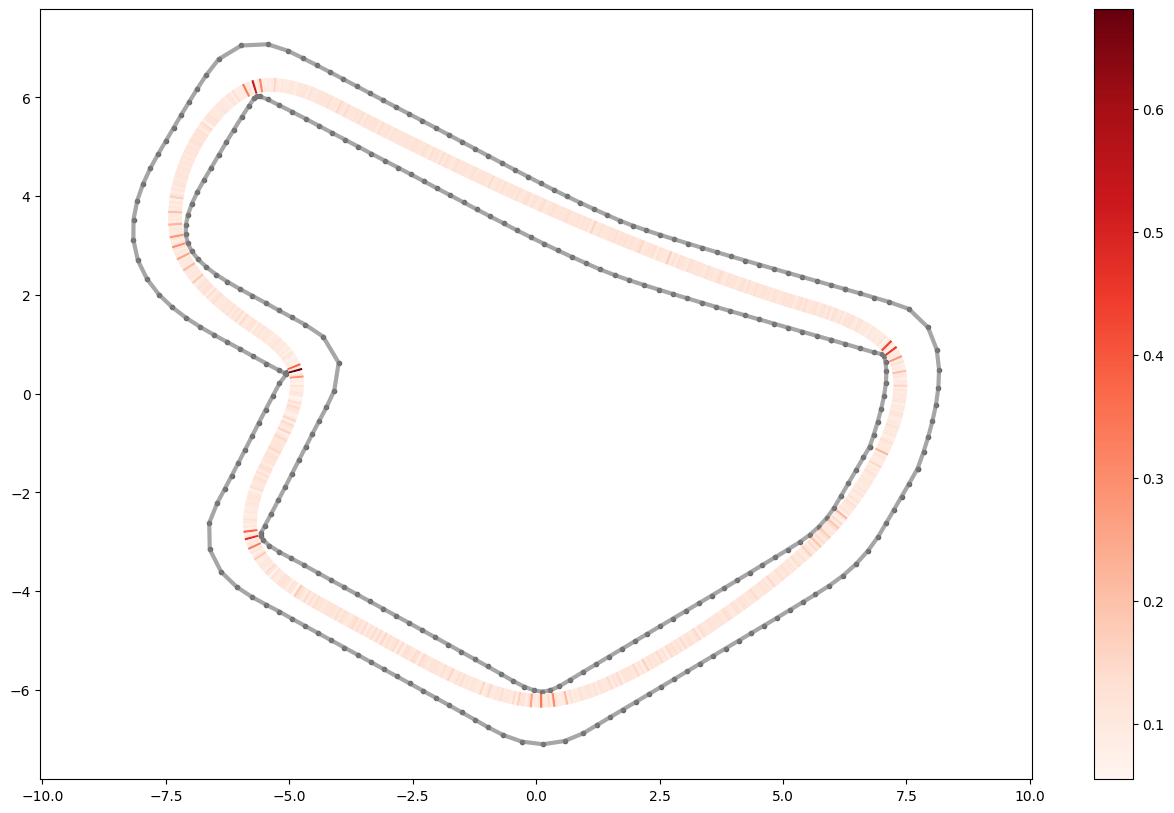

In [14]:
fig = helper_utils.plot_border(inner_border, outer_border)
segments = np.hstack((racing_line[:npoints, np.newaxis], np.roll(racing_line[:npoints], -1, axis=0)[:, np.newaxis]))
lc = LineCollection(segments, linewidths=10, cmap='Reds')
lc.set_array(waypoint_diff)
fig.gca().add_collection(lc)
fig.colorbar(lc)

In [15]:
#average distance between racing line waypoints
waypoint_avg_dist = np.sum(np.hypot(segments[:, 0, 0] - segments[:, 1, 0], segments[:, 0, 1] - segments[:, 1, 1])) / segments.shape[0]
waypoint_avg_dist

0.0520160692643844

In [16]:
#average distance between deepracer steps
distance_sum = 0
distance_num = 0
for ep in df['episode'].unique():
    coords = df[df['episode'] == ep][['x', 'y']].to_numpy()
    distance_sum += np.sum(np.hypot(coords[1:, 0] - coords[:-1, 0], coords[1:, 1] - coords[:-1, 1]))
    distance_num += len(coords) - 1

step_avg_dist = distance_sum / distance_num
step_avg_dist

0.05182031904264901

In [17]:
(abs(waypoint_avg_dist - step_avg_dist) / max(waypoint_avg_dist, step_avg_dist)) < 0.05

True

In [20]:
from datetime import datetime

now = datetime.now()
prefix = './progress-diffs/%s-%s' % (trackname, now.strftime('%Y-%m-%d-%H%M%S'))
arr_repr = helper_utils.array1D_repr_columns(waypoint_diff, 17)
helper_utils.export_ndarray(waypoint_diff, prefix, arr_repr)

Writing python code to ./progress-diffs/2022_september_open-2022-12-30-011315.py
Writing numpy binary to ./progress-diffs/2022_september_open-2022-12-30-011315.npy
